In [63]:
%reset

In [64]:
import sys
sys.path.append('/home/users/ids29/DGRB')

In [65]:
import aegis
import numpy as np
import healpy as hp
import torch
import pickle as pk
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from os import listdir
import os
from sbi.inference import SNPE #, prepare_for_sbi #, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
# from sbi.inference.base import infer
from getdist import plots, MCSamples
import pickle
from scipy.stats import norm, skew, kurtosis, spearmanr
from scipy.integrate import quad, simpson
from joblib import Parallel, delayed
from torch.optim import AdamW
from sbi.neural_nets import posterior_nn

torch.set_printoptions(precision=10, sci_mode=True)

%matplotlib inline

In [66]:
grains=1000
num_workers = 48  # or your chosen parallel worker count

NUM_ROUNDS     = 1
SIMS_PER_ROUND = int(1e3)          # Change only if the script that generates the data uses a different number of simulations
POST_SAMPLES   = 10_000            # how many samples for corner plot

prior_param_range = torch.load('theta_range_SFG1.pt')

LOW  =   prior_param_range[0,:]
HIGH =   prior_param_range[1,:]
print(f"LOW: {LOW}; HIGH: {HIGH}")
LABELS = [r"\log_{10}\Phi_{\rm SFG}"]

theta_test = torch.load('test_theta_SFG1_part2.pt')

use_energy_info = False

print('Completed')

LOW: tensor([-4]); HIGH: tensor([-1])
Completed


/tmp/ipykernel_1547310/2486108919.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  prior_param_range = torch.load('theta_range_SFG1.pt')
/tmp/ipykernel_1547310/2486108919

In [67]:
parameter_range = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range = [1000, 100000] #MeV
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*18]
max_radius = 8.5 + 20*2 #kpc
exposure = 2000*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
angular_cut = np.pi #10*u.deg.to('rad') #degrees
angular_cut_gen = np.pi #angular_cut*1.5
lat_cut = 0 #2*u.deg.to('rad') #degrees
lat_cut_gen = lat_cut*0.5


print('Completed')

Completed


In [68]:
my_cosmology = 'Planck18'
z_range = [0, 14]
luminosity_range = 10.0**np.array([37, 50]) # Minimum value set by considering Andromeda distance using Fermi as benchmark and receiving 0.1 photon at detector side
my_AEGIS = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, energy_range_gen=energy_range_gen, cosmology = my_cosmology, z_range = z_range, verbose = False)
my_AEGIS.angular_cut_gen, my_AEGIS.lat_cut_gen = angular_cut_gen, lat_cut_gen

print('Completed')

Completed


In [69]:
def compute_moments(values):
    """Compute the mean and variance of the energies."""
    mean = np.mean(values)
    var = np.var(values)
    skewness = skew(values)
    kurt = kurtosis(values)
    return mean, var, skewness, kurt

def compute_quantiles(values, quantiles=[10, 25, 50, 75, 90]):
    """
    Compute the specified quantiles (in percent).
    For example, the 25th quantile is the energy such that 25% of the data lies below it.
    Returns a dictionary mapping percentiles to values.
    """
    q_values = np.percentile(values, quantiles)
    return dict(zip(quantiles, q_values))

def normalize_quantiles(q_dict, val_min, val_max):
    """
    Normalize quantile values from a dictionary using min-max normalization.
    """
    norm_q = {perc: (val - val_min) / (val_max - val_min) for perc, val in q_dict.items()}
    return norm_q




def effective_spectral_index(energies, E_lower):
    """
    Compute effective spectral index via MLE.
    Returns np.nan if there are no photons.
    """
    energies = np.array(energies)
    n = len(energies)
    if n == 0:
        return np.nan
    sum_logs = np.sum(np.log(energies / E_lower))
    return 1 + n / sum_logs

def smooth_binned_gamma(binned_gamma, counts, global_gamma, min_count=6):
    """
    Smooth binned effective spectral indices if the count in a bin is low.
    
    Parameters:
      binned_gamma : array-like
          Array of spectral indices per energy bin (may contain np.nan for empty bins).
      counts : array-like
          Array of photon counts per bin.
      global_gamma : float
          Global effective spectral index, used as fallback.
      min_count : int
          Minimum photon count required to trust a bin.
    
    Returns:
      smoothed_gamma : numpy array with smoothed spectral index values.
    """
    binned_gamma = np.array(binned_gamma)
    counts = np.array(counts)
    num_bins = len(binned_gamma)
    smoothed_gamma = binned_gamma.copy()

    # Loop over each bin.
    for i in range(num_bins):
        if counts[i] < min_count or np.isnan(binned_gamma[i]):
            indices = [i]
            if i > 0:
                indices.append(i-1)
            if i < num_bins - 1:
                indices.append(i+1)
            indices = list(set(indices))  # ensure uniqueness
            
            # Only include indices with non-NaN values
            valid_indices = [j for j in indices if not np.isnan(binned_gamma[j])]
            if valid_indices:
                # Use the counts as weights. If any count is zero, it's fine; it will reduce the weight.
                weights = np.array([counts[j] for j in valid_indices], dtype=np.float32)
                # If all weights sum to 0, default to global_gamma.
                if np.sum(weights) > 0:
                    smoothed_gamma[i] = np.average(binned_gamma[valid_indices], weights=weights)
                else:
                    smoothed_gamma[i] = global_gamma
            else:
                # If none of the neighboring bins have a valid estimate, fallback to global_gamma.
                smoothed_gamma[i] = global_gamma
    return smoothed_gamma

def compute_binned_effective_spectral_indices(energies, num_bins, energy_range):
    """
    Divide the energy range into logarithmic bins and compute the effective spectral index in each bin.
    For bins with few photons (count < min_count) or empty bins, apply smoothing by averaging with neighboring bins.
    
    Returns:
      smoothed_gamma : 1D array containing the (possibly smoothed) spectral index for each bin.
      global_gamma  : Effective spectral index computed using all energies (with the lowest bin edge as E_lower).
      counts        : Raw photon counts per bin.
    """
    bins = np.geomspace(energy_range[0], energy_range[1], num_bins + 1)
    binned_gamma = []
    counts = []  # photon counts per bin

    # Loop over bins
    for i in range(len(bins) - 1):
        mask = (energies >= bins[i]) & (energies < bins[i+1])
        energies_bin = energies[mask]
        counts.append(len(energies_bin))
        # Compute gamma for the bin; if the bin is empty, effective_spectral_index returns np.nan.
        gamma = effective_spectral_index(energies_bin, E_lower=bins[i])
        binned_gamma.append(gamma)
    
    binned_gamma = np.array(binned_gamma)
    counts = np.array(counts)
    
    # Compute the global effective spectral index over all energies using the first bin's lower edge.
    global_gamma = effective_spectral_index(energies, E_lower=bins[0])
    
    # Smooth the binned_gamma using neighboring bins if counts in a bin are low.
    smoothed_gamma = smooth_binned_gamma(binned_gamma, counts, global_gamma, min_count=6)
    
    return smoothed_gamma, global_gamma, counts




def normalize_binned_gamma(binned_gamma, global_gamma, mode='ratio'):
    """
    Normalize the binned effective spectral indices relative to the global effective spectral index.
    
    Parameters:
      binned_gamma : np.array
          Array of effective spectral indices for each energy bin.
      global_gamma : float
          The global effective spectral index computed over the entire energy range.
      mode : str, optional
          'ratio' for normalized_binned_gamma = binned_gamma / global_gamma,
          'difference' for normalized_binned_gamma = (binned_gamma - global_gamma)/global_gamma.
          Default is 'ratio'.
    
    Returns:
      normalized_binned_gamma : np.array
    """
    if mode == 'ratio':
        # Return ratio relative to global spectral index
        normalized_binned_gamma = binned_gamma / global_gamma
    elif mode == 'difference':
        # Return relative differences with baseline 0
        normalized_binned_gamma = (binned_gamma - global_gamma) / global_gamma
    else:
        raise ValueError("Unknown mode for normalization. Choose 'ratio' or 'difference'.")
    return normalized_binned_gamma


# --- concise, log-binned 1-D energy histogram ---------------------------
def compute_energy_only_histogram(energies, num_bins, energy_range=(1000, 100_000)):
    """
    Log-bin photon energies (MeV) into `num_bins` and return raw counts.

    Parameters
    ----------
    energies      : 1-D iterable (list / np.ndarray / torch.Tensor)
    num_bins      : int, number of logarithmic bins
    energy_range  : (low, high) edges in MeV  (default 1–100 GeV)

    Returns
    -------
    hist : 1-D np.ndarray length `num_bins`  (integer counts)
    """
    edges = np.geomspace(energy_range[0], energy_range[1], num_bins + 1, dtype=np.float32)
    hist, _ = np.histogram(np.asarray(energies, dtype=np.float32), bins=edges)
    return hist.astype(np.float32)


def normalize_energy_only_hist(energy_only_hist):
    """
    Normalize a 1D histogram so it sums to 1.
    """
    total = np.sum(energy_only_hist) # this is the total number of photons in the energy-only histogram
    if total == 0:
        return energy_only_hist  # or handle the zero-case as needed
    return energy_only_hist / total

# def compute_sub_statistics(energies, counts, N_Ebins):
#     """
#     Given an array of photon energies (all between 1 and 100 GeV), compute a set of summary statistics:
#       1. Mean energy.
#       2. Variance of energy.
#       3. Quantiles: 10%, 25%, 50%, 75%, and 90%.
#       4. Effective spectral index estimated from the data.
      
#     Returns the statistics in a dictionary and also a flattened torch tensor.
#     """
#     # 1. Mean and variance
#     mean_E, var_E, skewness_E, kurt_E  = compute_moments(energies)
#     mean_counts, var_counts, skewness_counts, kurt_counts  = compute_moments(counts)
    
#     # 2. Quantiles
#     quant_dict_E = compute_quantiles(energies)  # This returns a dict like {10: val, 25: val, ...}
#     norm_quant_dict_E = normalize_quantiles(quant_dict_E, val_min=energy_range[0], val_max=energy_range[1])

#     quant_dict_counts = compute_quantiles(counts)  # This returns a dict like {10: val, 25: val, ...}
#     norm_quant_dict_counts = normalize_quantiles(quant_dict_counts, val_min=0, val_max=np.max(counts))

#     energy_only_hist = compute_energy_only_histogram(energies, num_bins=N_Ebins, energy_range=energy_range)

#     binned_gamma, global_gamma, energy_only_hist = compute_binned_effective_spectral_indices(energies, num_bins=N_Ebins, energy_range=energy_range)
#     norm_binned_gamma = normalize_binned_gamma(binned_gamma, global_gamma, mode='ratio')
#     norm_energy_only_hist = normalize_energy_only_hist(energy_only_hist)
    
#     # If you want to pass the summary statistic to sbi, it is best to use a fixed-size vector (e.g., a torch tensor).
#     # For example, arrange the stats in a consistent order:
#     scalars  = np.array([
#         energies.size, # total number of photons
#         mean_E, var_E , skewness_E, kurt_E,
#         mean_counts, var_counts, skewness_counts, kurt_counts,
#         global_gamma
#     ], dtype=np.float32)

    
#     return scalars , norm_quant_dict_E, norm_quant_dict_counts, norm_binned_gamma, norm_energy_only_hist

def compute_sub_statistics(energies, counts, N_Ebins):
    """
    Given an array of photon energies (all between 1 and 100 GeV), compute a set of summary statistics:
      1. Mean energy.
      2. Variance of energy.
      3. Quantiles: 10%, 25%, 50%, 75%, and 90%.
      4. Effective spectral index estimated from the data.
      
    Returns the statistics in a dictionary and also a flattened torch tensor.
    """
    # 1. Mean and variance
    mean_E, var_E, skewness_E, kurt_E  = compute_moments(energies)
    mean_counts, var_counts, skewness_counts, kurt_counts  = compute_moments(counts)
    
    # 2. Quantiles
    quant_dict_E = compute_quantiles(energies)  # This returns a dict like {10: val, 25: val, ...}
    norm_quant_dict_E = normalize_quantiles(quant_dict_E, val_min=energy_range[0], val_max=energy_range[1])

    quant_dict_counts = compute_quantiles(counts)  # This returns a dict like {10: val, 25: val, ...}
    norm_quant_dict_counts = normalize_quantiles(quant_dict_counts, val_min=0, val_max=np.max(counts))

    energy_only_hist = compute_energy_only_histogram(energies, num_bins=N_Ebins, energy_range=energy_range)

    binned_gamma, global_gamma, energy_only_hist = compute_binned_effective_spectral_indices(energies, num_bins=N_Ebins, energy_range=energy_range)
    norm_binned_gamma = normalize_binned_gamma(binned_gamma, global_gamma, mode='ratio')
    norm_energy_only_hist = normalize_energy_only_hist(energy_only_hist)
    
    # If you want to pass the summary statistic to sbi, it is best to use a fixed-size vector (e.g., a torch tensor).
    # For example, arrange the stats in a consistent order:
    energy_only_scalars  = np.array([
        mean_E, var_E , skewness_E, kurt_E,
        global_gamma
    ], dtype=np.float32)

    other_scalars  = np.array([
        energies.size, # log of total number of photons
        mean_counts, var_counts, skewness_counts, kurt_counts,
    ], dtype=np.float32)

    
    # USES NORMALIZED SUMMARIES
    # return energy_only_scalars, other_scalars, norm_quant_dict_E, norm_quant_dict_counts, norm_binned_gamma, norm_energy_only_hist

    # USES UNNORMALIZED SUMMARIES
    return energy_only_scalars, other_scalars, quant_dict_E, quant_dict_counts, binned_gamma, energy_only_hist

def normalize_energy_dependent_hist(energy_dependent_hist, total_pixels):
    """
    Normalize a 2D histogram so that each column sums to 1.
    total_pixels: the fixed number of pixels (for example, len(roi_pix_i))
    """
    # If the histogram is of shape (N_countbins, N_Ebins),
    # each column should ideally sum to total_pixels.
    normalized_hist = energy_dependent_hist / total_pixels
    return normalized_hist

def fano_from_photons(photon_info, nsides=(32, 64, 128), center_mask_deg=10, lat_mask_deg=5): #Outputs an array of Fano factors for each NSIDE (currently three in number).
    """
    photon_info must expose `theta` (co-latitude, rad) and `phi` (longitude, rad).
    Returns ΔF for each NSIDE in `nsides`.
    """
    # theta_p = photon_info['theta']   # or however your struct stores it
    # phi_p   = photon_info['phi']

    deltaF = []
    for N_side in nsides:

        N_pix = 12*N_side**2
        pix_i = np.linspace(0, N_pix-1, N_pix, dtype = 'int')
        roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask_deg*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask_deg*u.deg.to('rad')))[0]

        N_Ebins = 1 # This value doesn't matter because in 'get_roi_map_summary' fucntion, when you use 'Ebinspace = single', it will only consider one energy bin, and not use the N_Ebins value.
        roi_map_1D = my_AEGIS.get_roi_map_summary(photon_info = photon_info, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = 'single', roi_pix_i = roi_pix_i) # 'single' means only one energy bin.
        counts = roi_map_1D.ravel()

        #Fano excess
        mu  = counts.mean()
        var = counts.var()
        deltaF.append(max(0.0, var/mu - 1.0) if mu > 0 else 0.0)

    return np.asarray(deltaF, dtype=np.float32)



print('Completed')

Completed


In [70]:
# a simple simulator with the total number of photons as the summary statistic
def compute_summary_statistics(photon_info):

    N_side = 2**6
    #parameters for the summary statistic
    
    center_mask = 10 #deg 
    lat_mask = 5 #deg 
    N_Ebins = 20
    # Ebinspace = 'log'#'linear'
    N_countbins = 10
    countbinspace = 'custom'#'linear'
    mincount_2D_hist, maxcount_2D_hist = 0, 38 # For energy-dependent 2D histogram # Change for different data sets. Consider the data set with the maximum number of photons to decide the value of 'maxcount'.
    mincount_1D_counts_hist, maxcount_1D_counts_hist = 0, 123 # For counts only 1D histogram # Change for different data sets. Consider the data set with the maximum number of photons to decide the value of 'maxcount'.
    N_pix = 12*N_side**2
    pix_i = np.linspace(0, N_pix-1, N_pix, dtype = 'int')
    roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')))[0]

    # Get energy dependent 2D histogram
    roi_map_2D = my_AEGIS.get_roi_map_summary(photon_info = photon_info, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = 'log', roi_pix_i = roi_pix_i)
    # print(f"For energy-dependent hist, max counts = {np.max(roi_map)}; roi_map.shape = {roi_map.shape}")
    energy_dependent_hist = my_AEGIS.get_counts_histogram_from_roi_map(roi_map_2D, mincount = mincount_2D_hist, maxcount = maxcount_2D_hist, N_countbins = N_countbins, countbinspace = countbinspace)
    total_pixels = roi_pix_i.size
    norm_energy_dependent_hist = normalize_energy_dependent_hist(energy_dependent_hist, total_pixels)

    # Get counts-only 1D histogram
    roi_map_1D = my_AEGIS.get_roi_map_summary(photon_info = photon_info, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = 'single', roi_pix_i = roi_pix_i) # 'single' means only one energy bin.
    # print(f"For counts-only hist, max counts = {np.max(roi_map)}; roi_map.shape = {roi_map.shape}")
    counts_only_hist = my_AEGIS.get_counts_histogram_from_roi_map(roi_map_1D, mincount = mincount_1D_counts_hist, maxcount = maxcount_1D_counts_hist, N_countbins = N_countbins, countbinspace = countbinspace)
    total_pixels = roi_pix_i.size
    norm_counts_only_hist = normalize_energy_dependent_hist(counts_only_hist, total_pixels)


    photon_pixels = hp.ang2pix(N_side, photon_info['angles'][:, 0], photon_info['angles'][:, 1])
    roi_mask = np.isin(photon_pixels, roi_pix_i)
    energies_in_roi = photon_info['energies'][roi_mask]

    counts = roi_map_1D.ravel()
    energy_only_scalars, other_scalars, norm_quant_dict_E, norm_quant_dict_counts, norm_binned_gamma, norm_energy_only_hist = compute_sub_statistics(energies_in_roi, counts, N_Ebins = N_Ebins) # Original code
    
    QUANTILES = [10, 25, 50, 75, 90]
    sorted_keys_E = sorted(norm_quant_dict_E.keys())
    assert sorted_keys_E == QUANTILES, "Quantile keys differ from expected set"
    norm_quant_vector_E = np.array([norm_quant_dict_E[k] for k in sorted_keys_E], dtype=np.float32)

    sorted_keys_counts = sorted(norm_quant_dict_counts.keys())
    assert sorted_keys_counts == QUANTILES, "Quantile keys differ from expected set"
    norm_quant_vector_counts = np.array([norm_quant_dict_counts[k] for k in sorted_keys_counts], dtype=np.float32)

    flat_norm_energy_dependent_hist = np.asarray(norm_energy_dependent_hist, dtype=np.float32).flatten()
    flat_norm_counts_only_hist = np.asarray(norm_counts_only_hist, dtype=np.float32).flatten()

    fano_factors = fano_from_photons(photon_info, center_mask_deg=center_mask, lat_mask_deg=lat_mask) # evaluated at N-sides 32, 64, and 128

    # USES NORMALIZED SUMMARIES

    # if use_energy_info:
    #     ## This is the full summary statistic array
    #     parts = [          
    #         energy_only_scalars,                                         # scalars that depend only on energy
    #         other_scalars,                                              # scalars that don't depend on energy
    #         np.array([np.max(counts)], dtype=np.float32), # max counts that any pixel sees
    #         fano_factors,
    #         norm_quant_vector_E,
    #         norm_quant_vector_counts,
    #         norm_binned_gamma,
    #         norm_energy_only_hist,
    #         flat_norm_counts_only_hist,
    #         flat_norm_energy_dependent_hist
    #     ]
    # else:
    #     ## This is the reduced summary statistic array, which excludes energy-only information
    #     parts = [          
    #         other_scalars,                                          # all features except the scalars
    #         np.array([np.max(counts)], dtype=np.float32), # max counts that any pixel sees
    #         fano_factors,
    #         norm_quant_vector_counts,
    #         flat_norm_counts_only_hist,
    #         flat_norm_energy_dependent_hist
    #     ]

    # USES uNNORMALIZED SUMMARIES

    # if use_energy_info:
    #     ## This is the full summary statistic array
    #     parts = [          
    #         energy_only_scalars,                                         # scalars that depend only on energy
    #         other_scalars,                                              # scalars that don't depend on energy
    #         np.array([np.max(counts)], dtype=np.float32), # max counts that any pixel sees
    #         fano_factors,
    #         norm_quant_vector_E,
    #         norm_quant_vector_counts,
    #         norm_binned_gamma,
    #         norm_energy_only_hist,
    #         np.asarray(counts_only_hist, dtype=np.float32).flatten(),
    #         np.asarray(energy_dependent_hist, dtype=np.float32).flatten()
    #     ]
    # else:
    #     ## This is the reduced summary statistic array, which excludes energy-only information
    #     parts = [          
    #         other_scalars,                                          # all features except the scalars
    #         np.array([np.max(counts)], dtype=np.float32), # max counts that any pixel sees
    #         fano_factors,
    #         norm_quant_vector_counts,
    #         np.asarray(counts_only_hist, dtype=np.float32).flatten(),
    #         np.asarray(energy_dependent_hist, dtype=np.float32).flatten()
    #     ]


    # TRYING TO REDUCE THE NUMBER OF SUMMARIES
    parts = [
        np.array([other_scalars[0]])
    ]

    summary_array = np.concatenate(parts, axis=0)
    
    return torch.as_tensor(summary_array, dtype=torch.float32)   # stays on CPU

print('Completed')

Completed


x_o_full = tensor([1.0760000000e+03])


/tmp/ipykernel_1547310/424009517.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  θ_batch = torch.load('training_theta_SFG1.pt') # thetas used for training dataset



──────────  ROUND 1/1  ──────────


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:   13.3s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:   13.6s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:   13.8s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   14.0s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   14.1s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   14.3s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   14.5s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   14.7s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   14.9s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   15.2s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   15.7s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   17.0s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

 Neural network successfully converged after 363 epochs.

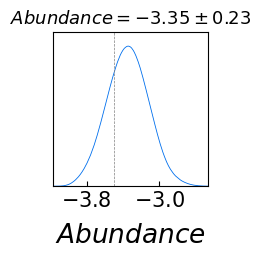

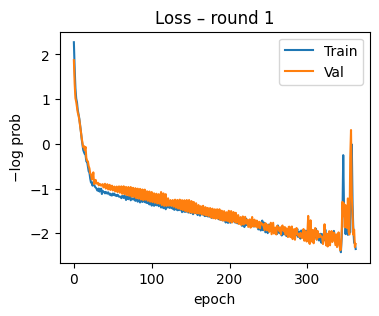

Drawing 10000 posterior samples for 1 observations:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in

All rounds finished.  Close the figures to exit.


In [71]:
# ------------------------------------------------------------------ #
# 5.  Initialise
# ------------------------------------------------------------------ #
prior     = utils.BoxUniform(LOW, HIGH, device="cpu")   # cpu for sampling speed
with open('test_photon_info_SFG1_part2.pkl', 'rb') as f:
    raw_o = pickle.load(f) # raw photon data for test case
x_o_full  = compute_summary_statistics(raw_o)       # 1-D tensor  (D_full,)
print(f"x_o_full = {x_o_full}")


θ_batch = torch.load('training_theta_SFG1.pt') # thetas used for training dataset
with open('training_photon_info_SFG1.pkl', 'rb') as f:
    raw_training = pickle.load(f) # raw photon data for training dataset





Θ_accum, X_accum = [], []           # running simulation database
proposal = prior                    # start broad
plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# resume_flag = False   # Nothing to resume yet



for r in range(1, NUM_ROUNDS + 1):
    print(f"\n──────────  ROUND {r}/{NUM_ROUNDS}  ──────────")

    # 5.1  Draw parameters
    # if r == 1:
    #     θ_batch = prior.sample((SIMS_PER_ROUND,))    # (N,2) cpu
    # else:
    #     θ_batch = proposal.sample((SIMS_PER_ROUND,), x=x_o_z).cpu()

    # 5.2  Simulate & summarise
    # summaries = []
    # for θ in θ_batch:
    #     raw   = simulate_raw_photon_data(θ)
    #     summ  = compute_summary_statistics(raw)
    #     summaries.append(summ)
    # x_batch_full = torch.stack(summaries)            # (N, D_full)
    
    # def simulate_and_summarize(theta):
    #     raw  = simulate_raw_photon_data(theta)
    #     return compute_summary_statistics(raw)

    # dispatch 48 parallel jobs
    summaries = Parallel(
        n_jobs=num_workers,           # number of worker processes
        backend="loky",      # default multiprocess backend
        verbose=10           # progress output
    )(
        delayed(compute_summary_statistics)(raw) 
        for raw in raw_training
    )

    # stack back into a tensor
    x_batch_full = torch.stack(summaries)  # shape: (SIMS_PER_ROUND, D_full)

    # 5.3  Append to global store
    Θ_accum.append(θ_batch)
    X_accum.append(x_batch_full)
    Θ_all = torch.cat(Θ_accum, 0)                    # (N_tot,2)
    X_all_full = torch.cat(X_accum, 0)               # (N_tot,D_full)


    X_z = X_all_full
    x_o_z = x_o_full

    

    # 5.6  Build / update inference object
    if r == 1:
        # network
        net = posterior_nn(model="nsf", hidden_features=64, num_transforms=4,
                           dropout_probability=0.4, use_combined_loss=True,
                           z_score_x="none", z_score_theta="none")
        inf = SNPE(prior=prior)
        


    inf.append_simulations(
            θ_batch.to(device),        # θ from this round only
            X_z.to(device),      # summaries from this round only
    )


    # inf.append_simulations(Θ_all.to(device), X_z.to(device))

    de = inf.train()

    # de = inf.train(
    #     training_batch_size=256, learning_rate=1e-3,
    #     validation_fraction=0.2, stop_after_epochs=50, max_num_epochs=500,
    #     show_train_summary=False, clip_max_norm=1.0,
    #     optimizer_class=AdamW,
    #     optimizer_kwargs={"lr": 1e-3, "weight_decay": 5e-5})
    
    # resume_flag = True   # from now on the attribute exists

    # 5.7  Loss curves
    hist = inf._summary
    fig_loss = plt.figure(figsize=(4,3))
    plt.plot(hist["training_loss"],   label="Train")
    plt.plot(hist["validation_loss"], label="Val")
    plt.xlabel("epoch"); plt.ylabel("−log prob"); plt.legend()
    plt.title(f"Loss – round {r}")
    plt.show()

    # 5.8  Posterior & sampling
    posterior = inf.build_posterior(de)




    parameter_names = ['Source1']
    parameter_labels = ['Abundance']
    samples = posterior.sample((10000,), x=x_o_z) #100000
    ranges = dict(zip(parameter_names, np.array(parameter_range).T.reshape((np.array(parameter_range[0]).size,2))))
    mcsamples = MCSamples(samples=samples.numpy(), names = parameter_names, labels = parameter_labels, ranges = ranges)

    g = plots.get_subplot_plotter()
    g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
    g.settings.axes_fontsize=18
    g.settings.legend_fontsize = 26
    g.settings.axes_labelsize = 22
    g.settings.norm_1d_density = True
    g.settings.title_limit = 1
    g.triangle_plot(mcsamples, filled=True, markers=theta_test.numpy(), param_limits=ranges)
    # g.plot_1d([mcsamples], ['Source1'], filled=True)


print("\nAll rounds finished.  Close the figures to exit.")
plt.ioff()